In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
import pickle
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')

import asurv

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Get all of the data for the BAT AGN

In [384]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
bat_c12.loc['UGC06728', 'lir_sf'] += 2.0
bat_c12.loc['UGC06728', 'mdust'] += 2.0


bat_decompir = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/analysis/decompir_results/sb+arp220/final_fit_results_decompir_sb_and_arp220_mle.csv', index_col=0)
bat_decompir_uncertain = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/analysis/decompir_results/sb+arp220/final_fit_results_decompir_sb_and_arp220_uncertainties.csv', index_col=0)
bat_decompir = bat_decompir.join(bat_decompir_uncertain)
bat_decompir_undetected = pd.read_csv(sed_fit_dir+'analysis/decompir_results/sb+arp220/final_fit_results_decompir_sb_and_arp220_undetected.csv', index_col=0)
bat_decompir.drop(radio_loud_sources)

bat_c12['agn_frac_decompir'] = bat_decompir['agn_frac']

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_c12['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))


# Calculate the SFR
bat_c12['sfr'] = bat_c12['lir_sf'] + np.log10(3.846e33) - np.log10(2.57e43)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12)

bat_c12['LBAT'] = bat_flux['LBAT']

Group the Type 1s and 2s together. We'll put anything with a classification of Type 1.5 or lower as a Sy 1. And everything above as a Sy 2.

In [382]:
broad_type = pd.Series(index=bat_info.index, name='Sy_Type')

for n in bat_info.index.values:

    type_split = bat_info.loc[n, 'Seyfert_Type'].split()

    if ((type_split[0] == 'Sy')):
        if ((type_split[1] == '1') | (type_split[1] == '1.2') | (type_split[1] == '1.4') | (type_split[1] == '1.5')):

            broad_type.loc[n] = 'Sy 1'
            
        elif ((type_split[1] == '2') | (type_split[1] == '1.8') | (type_split[1] == '1.9')):
            
            broad_type.loc[n] = 'Sy 2'
    else:

        if (type_split[0] == 'LINER'):
            
            broad_type.loc[n] = 'LINER'

        elif (type_split[0] == 'AGN'):
            
            broad_type.loc[n] = 'AGN'

In [386]:
bat_c12['Sy_Type'] = broad_type
bat_sy1 = bat_c12[bat_c12['Sy_Type'] == 'Sy 1']
bat_sy2 = bat_c12[bat_c12['Sy_Type'] == 'Sy 2']

## Dust Mass, Dust Temperature, and SFR Comparison

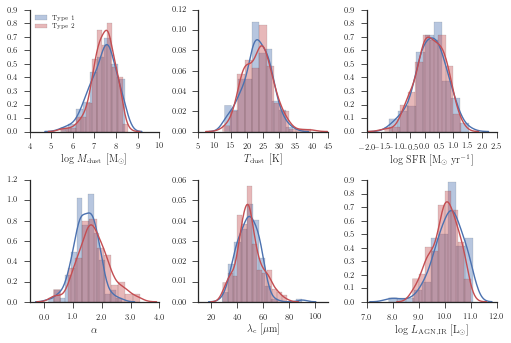

In [369]:
fig = plt.figure(figsize=(1.2*textwidth, 1/2.*1.5*textwidth))
ax1 = fig.add_subplot(231)
sn.distplot(bat_sy1[bat_sy1['mdust_flag'] == 0]['mdust'].dropna(), label='Type 1', color='b', ax=ax1)
sn.distplot(bat_sy2[bat_sy2['mdust_flag'] == 0]['mdust'].dropna(), label='Type 2', color='r', ax=ax1)
plt.xlabel(r'$\log\,M_{\rm dust}$ [M$_{\odot}$]')
plt.legend(loc='upper left', fontsize=6)
sn.despine()

ax2 = fig.add_subplot(232)
sn.distplot(bat_sy1['tdust'].dropna(), label='Type 1', color='b', ax=ax2)
sn.distplot(bat_sy2['tdust'].dropna(), label='Type 2', color='r', ax=ax2)
plt.xlabel(r'$T_{\rm dust}$ [K]')

ax3 = fig.add_subplot(233)
sn.distplot(bat_sy1[bat_sy1['lir_sf_flag'] == 0]['sfr'].dropna(), label='Type 1', color='b', ax=ax3)
sn.distplot(bat_sy2[bat_sy2['lir_sf_flag'] == 0]['sfr'].dropna(), label='Type 2', color='r', ax=ax3)
plt.xlabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
sn.despine()

ax4 = fig.add_subplot(234)
sn.distplot(bat_sy1['alpha'].dropna(), label='Type 1', color='b', ax=ax4)
sn.distplot(bat_sy2['alpha'].dropna(), label='Type 2', color='r', ax=ax4)
plt.xlabel(r'$\alpha$')
ax4.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0, 4.0])
ax4.xaxis.set_ticklabels(['0.0', '1.0', '2.0', '3.0', '4.0'])
sn.despine()

ax5 = fig.add_subplot(235)
sn.distplot(bat_sy1['wturn'].dropna(), label='Type 1', color='b', ax=ax5)
sn.distplot(bat_sy2['wturn'].dropna(), label='Type 2', color='r', ax=ax5)
plt.xlabel(r'$\lambda_{\rm c}$ [$\mu$m]')


ax6 = fig.add_subplot(236)
sn.distplot(bat_sy1[bat_sy1['lir_agn_flag'] == 0]['lir_agn'].dropna(), label='Type 1', color='b', ax=ax6)
sn.distplot(bat_sy2[bat_sy2['lir_agn_flag'] == 0]['lir_agn'].dropna(), label='Type 2', color='r', ax=ax6)
plt.xlabel(r'$\log\,L_{\rm AGN,IR}$ [L$_{\odot}$]')
ax6.xaxis.set_ticks([7.0, 8.0, 9.0, 10.0, 11.0, 12.0])
ax6.xaxis.set_ticklabels(['7.0', '8.0', '9.0', '10.0', '11.0', '12.0'])
sn.despine()
fig.subplots_adjust(wspace=0.3, hspace=0.4)

#fig.savefig('../figures/agn_type_comparison.pdf', bbox_inches='tight')

##Analysis with Undetected Sources

In [298]:
bat_mdust_type1_km = asurv.KaplanMeierDist(bat_sy1['mdust'][bat_sy1['mdust'] > 6.].values, bat_sy1['mdust_flag'][bat_sy1['mdust'] > 6.].values+1)

bat_mdust_type2_km = asurv.KaplanMeierDist(bat_sy2['mdust'][bat_sy2['mdust'] > 6.].values, bat_sy2['mdust_flag'][bat_sy2['mdust'] > 6.].values+1)

bat_mdust_type1_km_mean = bat_mdust_type1_km.km_mean()
bat_mdust_type2_km_mean = bat_mdust_type2_km.km_mean()

print 'Mean log(Dust Mass) with upper limits:'
print 'Type 1: ', bat_mdust_type1_km_mean[0], '+/-', bat_mdust_type1_km_mean[1]
print 'Type 2: ', bat_mdust_type2_km_mean[0], '+/-', bat_mdust_type2_km_mean[1]

Mean log(Dust Mass) with upper limits:
Type 1:  7.29005464897 +/- 0.0575369523611
Type 2:  7.37797467176 +/- 0.0430867113757


In [230]:
bat_tdust_type1_km = asurv.KaplanMeierDist(bat_sy1['tdust'].dropna().values, cens=bat_sy1['tdust_flag'].dropna().values+1)

bat_tdust_type2_km = asurv.KaplanMeierDist(bat_sy2['tdust'].dropna().values, cens=bat_sy2['tdust_flag'].dropna().values+1)

bat_tdust_type1_km_mean = bat_tdust_type1_km.km_mean()
bat_tdust_type2_km_mean = bat_tdust_type2_km.km_mean()

print 'Mean Dust Temperature with upper limits:'
print 'Type 1: ', bat_tdust_type1_km_mean[0], '+/-', bat_tdust_type1_km_mean[1]
print 'Type 2: ', bat_tdust_type2_km_mean[0], '+/-', bat_tdust_type2_km_mean[1]

Mean Dust Temperature with upper limits:
Type 1:  23.2111035457 +/- 0.407153254308
Type 2:  23.5497664787 +/- 0.359356652203


In [300]:
sy1_sfr_cens = bat_sy1['lir_sf_flag'][bat_sy1['sfr'] > -1.].values+1
sy1_sfr_cens[sy1_sfr_cens == 2] = 1
sy2_sfr_cens = bat_sy2['lir_sf_flag'][bat_sy2['sfr'] > -1.].values+1
sy2_sfr_cens[sy2_sfr_cens == 2] = 1

bat_sfr_type1_km = asurv.KaplanMeierDist(bat_sy1['sfr'][bat_sy1['sfr'] > -1.].values, sy1_sfr_cens)
bat_sfr_type2_km = asurv.KaplanMeierDist(bat_sy2['sfr'][bat_sy2['sfr'] > -1.].values, sy2_sfr_cens)

bat_sfr_type1_km_mean = bat_sfr_type1_km.km_mean()
bat_sfr_type2_km_mean = bat_sfr_type2_km.km_mean()

print 'Mean log(SFR) with upper limits:'
print 'Type 1: ', bat_sfr_type1_km_mean[0], '+/-', bat_sfr_type1_km_mean[1]
print 'Type 2: ', bat_sfr_type2_km_mean[0], '+/-', bat_sfr_type2_km_mean[1]

Mean log(SFR) with upper limits:
Type 1:  0.108646235903 +/- 0.052223234585
Type 2:  0.226787613181 +/- 0.0430493927228


In [256]:
bat_alpha_type1_km = asurv.KaplanMeierDist(bat_sy1['alpha'].dropna().values, cens=bat_sy1['alpha_flag'].dropna().values+1)

bat_alpha_type2_km = asurv.KaplanMeierDist(bat_sy2['alpha'].dropna().values, cens=bat_sy2['alpha_flag'].dropna().values+1)

bat_alpha_type1_km_mean = bat_alpha_type1_km.km_mean()
bat_alpha_type2_km_mean = bat_alpha_type2_km.km_mean()

print 'Mean Powerlaw Slope with upper limits:'
print 'Type 1: ', bat_alpha_type1_km_mean[0], '+/-', bat_alpha_type1_km_mean[1]
print 'Type 2: ', bat_alpha_type2_km_mean[0], '+/-', bat_alpha_type2_km_mean[1]

Mean Powerlaw Slope with upper limits:
Type 1:  1.46272070942 +/- 0.036150389416
Type 2:  1.7259028214 +/- 0.043633859175


In [257]:
bat_wturn_type1_km = asurv.KaplanMeierDist(bat_sy1['wturn'].dropna().values, cens=bat_sy1['wturn_flag'].dropna().values+1)

bat_wturn_type2_km = asurv.KaplanMeierDist(bat_sy2['wturn'].dropna().values, cens=bat_sy2['wturn_flag'].dropna().values+1)

bat_wturn_type1_km_mean = bat_wturn_type1_km.km_mean()
bat_wturn_type2_km_mean = bat_wturn_type2_km.km_mean()

print 'Mean Turnover Wavelength with upper limits:'
print 'Type 1: ', bat_wturn_type1_km_mean[0], '+/-', bat_wturn_type1_km_mean[1]
print 'Type 2: ', bat_wturn_type2_km_mean[0], '+/-', bat_wturn_type2_km_mean[1]

Mean Turnover Wavelength with upper limits:
Type 1:  48.7416218439 +/- 0.750857277409
Type 2:  49.382859506 +/- 0.743958078702


In [260]:
sy1_lir_agn_cens = bat_sy1['lir_agn_flag'].values+1
sy1_lir_agn_cens[sy1_lir_agn_cens == 2] = 1
sy2_lir_agn_cens = bat_sy2['lir_agn_flag'].values+1
sy2_lir_agn_cens[sy2_lir_agn_cens == 2] = 1

bat_lir_agn_type1_km = asurv.KaplanMeierDist(bat_sy1['lir_agn'].values, sy1_lir_agn_cens)
bat_lir_agn_type2_km = asurv.KaplanMeierDist(bat_sy2['lir_agn'].values, sy2_lir_agn_cens)

bat_lir_agn_type1_km_mean = bat_lir_agn_type1_km.km_mean()
bat_lir_agn_type2_km_mean = bat_lir_agn_type2_km.km_mean()

print 'Mean log(LAGNIR) with upper limits:'
print 'Type 1: ', bat_lir_agn_type1_km_mean[0], '+/-', bat_lir_agn_type1_km_mean[1]
print 'Type 2: ', bat_lir_agn_type2_km_mean[0], '+/-', bat_lir_agn_type2_km_mean[1]

Mean log(LAGNIR) with upper limits:
Type 1:  10.0002897863 +/- 0.0568139516916
Type 2:  9.708583055 +/- 0.0672669911676


##Two-sample tests

In [299]:
mdust_2samp_seyferts = asurv.two_sample_tests(bat_mdust_type1_km.data, bat_mdust_type1_km.cens,
                                              bat_mdust_type2_km.data, bat_mdust_type2_km.cens)

print 'Type 1 vs. Type 2 Mdust: ', mdust_2samp_seyferts['Peto-Prentice']['p-value']

Type 1 vs. Type 2 Mdust:  0.257810576514


In [242]:
tdust_2samp_seyferts = asurv.two_sample_tests(bat_tdust_type1_km.data, bat_tdust_type1_km.cens,
                                              bat_tdust_type2_km.data, bat_tdust_type2_km.cens)

print 'Type 1 vs. Type 2 Tdust: ', tdust_2samp_seyferts['Peto-Prentice']['p-value']

Type 1 vs. Type 2 Tdust:  0.733361554486


In [301]:
sfr_2samp_seyferts = asurv.two_sample_tests(bat_sfr_type1_km.data, bat_sfr_type1_km.cens,
                                            bat_sfr_type2_km.data, bat_sfr_type2_km.cens)

print 'Type 1 vs. Type 2 SFR: ', sfr_2samp_seyferts['Peto-Prentice']['p-value']

Type 1 vs. Type 2 SFR:  0.0940463090662


In [261]:
alpha_2samp_seyferts = asurv.two_sample_tests(bat_alpha_type1_km.data, bat_alpha_type1_km.cens,
                                              bat_alpha_type2_km.data, bat_alpha_type2_km.cens)

print 'Type 1 vs. Type 2 alpha: ', alpha_2samp_seyferts['Peto-Prentice']['p-value']

Type 1 vs. Type 2 alpha:  2.6282967515e-05


In [262]:
wturn_2samp_seyferts = asurv.two_sample_tests(bat_wturn_type1_km.data, bat_wturn_type1_km.cens,
                                              bat_wturn_type2_km.data, bat_wturn_type2_km.cens)

print 'Type 1 vs. Type 2 Wturn: ', wturn_2samp_seyferts['Peto-Prentice']['p-value']

Type 1 vs. Type 2 Wturn:  0.733512706101


In [263]:
lir_agn_2samp_seyferts = asurv.two_sample_tests(bat_lir_agn_type1_km.data, bat_lir_agn_type1_km.cens,
                                              bat_lir_agn_type2_km.data, bat_lir_agn_type2_km.cens)

print 'Type 1 vs. Type 2 LAGNIR: ', lir_agn_2samp_seyferts['Peto-Prentice']['p-value']

Type 1 vs. Type 2 LAGNIR:  0.00333270676974


##AGN Fraction Comparison

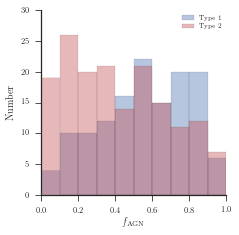

In [274]:
fig = plt.figure(figsize=(columnwidth, columnwidth))
ax1 = fig.add_subplot(111)
sn.distplot(bat_sy1['agn_frac'], label='Type 1', color='b', ax=ax1, kde=False, bins=np.arange(0,1.1, 0.1))
sn.distplot(bat_sy2['agn_frac'], label='Type 2', color='r', ax=ax1, kde=False, bins=np.arange(0,1.1, 0.1))
plt.xlabel(r'$f_{\rm AGN}$')
plt.ylabel(r'Number')
plt.legend(loc='upper right', fontsize=6)
sn.despine()

fig.savefig(figsave_dir+'fagn_ir_seyferts.pdf', bbox_inches='tight')

In [283]:
print 'Mean AGN Fraction Type 1: ', np.mean(bat_sy1['agn_frac'])
print 'Mean AGN Fraction Type 2: ', np.mean(bat_sy2['agn_frac'])
stats.ks_2samp(bat_sy1['agn_frac'], bat_sy2['agn_frac'])

Mean AGN Fraction Type 1:  0.560255599016
Mean AGN Fraction Type 2:  0.42482320212


Ks_2sampResult(statistic=0.26996876394466762, pvalue=2.7649157281339231e-05)

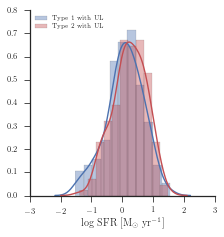

In [297]:
fig = plt.figure(figsize=(columnwidth, columnwidth))
ax1 = fig.add_subplot(111)
sn.distplot(bat_sy1['sfr'], label='Type 1 with UL', color='b', ax=ax1)
sn.distplot(bat_sy2['sfr'], label='Type 2 with UL', color='r', ax=ax1)
plt.xlabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
plt.legend(loc='upper left', fontsize=6)
sn.despine()

fig.savefig(figsave_dir+'sfr_comp_with_ul_seyferts.pdf', bbox_inches='tight')

In [387]:
bat_sy2[bat_sy2['alpha'] > 2.2][['agn_frac', 'agn_frac_flag', 'agn_frac_decompir']]

,agn_frac,agn_frac_flag,agn_frac_decompir
Name,,,
2MASXJ03305218+0538253,0.853714,0,9.225185e-01
2MASXJ15462424+6929102,0.594847,0,5.047603e-01
ESO103-035,0.809202,0,9.346197e-01
ESO509-IG066NED01,0.343743,0,9.387782e-02
IC1657,0.565041,0,9.074652e-02
IC1816,0.184999,0,2.271211e-01
IC2461,0.250716,0,2.535026e-02
IC4518A,0.412072,0,2.114212e-01
IC5063,0.839313,0,8.049366e-01


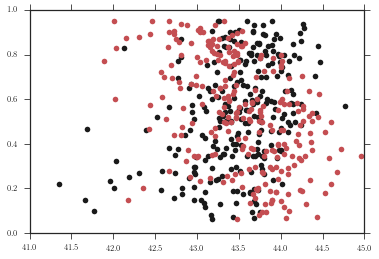

In [399]:
plt.plot(np.log10(bat_c12[bat_c12['agn_frac_flag'] >= 0]['LBAT']), bat_c12[bat_c12['agn_frac_flag'] >= 0]['agn_frac'], 'ko')
plt.plot(bat_c12[bat_c12['agn_frac_flag'] >= 0]['lir_sf'] +np.log10(3.846e33), bat_c12[bat_c12['agn_frac_flag'] >= 0]['agn_frac'], 'ro')